In [1]:
from func.utils import get_model_output_id_wnid_class_dict # get mapping: format: {"Model Ouput ID": ["WNID", "Class"]}
from func.utils import get_imagenet_id_wnid_class_dict # get mapping: format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
from func.utils import map_model_id_to_imagenet_id, map_imagenet_id_to_model_id # mapping funcs

from func.utils import save_obj, load_obj, preprocess_image, get_pretrained_model

from func.saliency_maps import conduct_saliency_map_method, GuidedBackprop, VanillaBackprop, SmoothGrad, GradCAM, GuidedGradCAM, IntegratedGradients, GradientxInput

from func.responsible_regions import load_responsible_regions_from_given_path, X_y_preparation, process_cat_saliency_map

from func.concept_classifier import get_linear_classifier, get_xgb_classifier, prediction

from func.show import load_feature_saliency_map_and_resized_img_for_show, show_concept_region_on_img

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import gc
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
from skimage.transform import resize


In [2]:
# get the dict of ImageNet ID, WNID and class name
# format: {"ImageNet ID": ["WNID", "class"]}, e.g. {..."233": ['n02106382', 'Bouvier_des_Flandres'], ...}
imagenet_id_label=get_imagenet_id_wnid_class_dict(matfilepath = "imagenet_info/ILSVRC2012_meta.mat")

# get the dict of model output ID, WNID and class name
# format: {"Model Ouput ID": ["WNID", "Class"]}
modeloutput_id_label=get_model_output_id_wnid_class_dict(jsonfilepath = "imagenet_info/imagenet_label_index.json")

# get dict map model output ID to ImageNet ID
map_dict_model2imagenet=map_model_id_to_imagenet_id(imagenet_id_label, modeloutput_id_label)

# get ImageNet ID to dict map model output ID
map_dict_imagenet2model=map_imagenet_id_to_model_id(imagenet_id_label, modeloutput_id_label)

### show image classes

In [3]:
# only 1~1000 is valid
for idx in imagenet_id_label:
    print(str(idx)+": "+str(imagenet_id_label[idx]))

1: ['n02119789', 'kit fox, Vulpes macrotis']
2: ['n02100735', 'English setter']
3: ['n02110185', 'Siberian husky']
4: ['n02096294', 'Australian terrier']
5: ['n02102040', 'English springer, English springer spaniel']
6: ['n02066245', 'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus']
7: ['n02509815', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens']
8: ['n02124075', 'Egyptian cat']
9: ['n02417914', 'ibex, Capra ibex']
10: ['n02123394', 'Persian cat']
11: ['n02125311', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor']
12: ['n02423022', 'gazelle']
13: ['n02346627', 'porcupine, hedgehog']
14: ['n02077923', 'sea lion']
15: ['n02110063', 'malamute, malemute, Alaskan malamute']
16: ['n02447366', 'badger']
17: ['n02109047', 'Great Dane']
18: ['n02089867', 'Walker hound, Walker foxhound']
19: ['n02102177', 'Welsh springer spaniel']
20: ['n02091134', 'whippet']
21: ['n02092002', 'Scottish deerhound, deerhound']
22: [

1627: ['n03666917', 'lighter-than-air craft']
1628: ['n04530566', 'vessel, watercraft']
1629: ['n02858304', 'boat']
1630: ['n03790230', 'motorboat, powerboat']
1631: ['n04158807', 'sea boat']
1632: ['n04244997', 'small boat']
1633: ['n04128837', 'sailing vessel, sailing ship']
1634: ['n04128499', 'sailboat, sailing boat']
1635: ['n04194289', 'ship']
1636: ['n02965300', 'cargo ship, cargo vessel']
1637: ['n03896103', 'passenger ship']
1638: ['n04552696', 'warship, war vessel, combat ship']
1639: ['n04348184', 'submersible, submersible warship']
1640: ['n03764276', 'military vehicle']
1641: ['n04099429', 'rocket, projectile']
1642: ['n04235291', 'sled, sledge, sleigh']
1643: ['n03678362', 'litter']
1644: ['n04019101', 'public transport']
1645: ['n04468005', 'train, railroad train']
1646: ['n03896233', 'passenger train']
1647: ['n02924116', 'bus, autobus, coach, charabanc, double-decker, jitney, motorbus, motorcoach, omnibus, passenger vehicle']
1648: ['n03091374', 'connection, connexion,

### imagenet parent and child dict

In [4]:
imagenet_class_parent_and_child_dict = load_obj("imagenet_info/imagenet_class_dict")

### show CUB images

In [5]:
# set the path to CUB 200 2011 dataset
cub_path = "/data/CUB-200-2011/CUB_200_2011"

In [6]:
cub_img_name_list_path = cub_path+"/images.txt"
cub_class_list_path = cub_path+"/classes.txt"
cub_img_label_list_path = cub_path+"/image_class_labels.txt"
cub_bounding_boxes_list_path = cub_path+"/bounding_boxes.txt"

cub_img_name_df = pd.read_csv(cub_img_name_list_path, header = None, sep="\s+", names=["img_idx", "path"])
cub_bounding_boxes_df = pd.read_csv(cub_bounding_boxes_list_path, header = None, sep="\s+", names=["img_idx", "x", "y", "width", "height"])
cub_bounding_boxes_df["path"] = cub_img_name_df["path"]

In [7]:
cub_bounding_boxes_df

,img_idx,x,y,width,height,path
0,1,60.0,27.0,325.0,304.0,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,139.0,30.0,153.0,264.0,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,14.0,112.0,388.0,186.0,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,112.0,90.0,255.0,242.0,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,70.0,50.0,134.0,303.0,001.Black_footed_Albatross/Black_Footed_Albatr...
...,...,...,...,...,...,...
11783,11784,89.0,95.0,354.0,250.0,200.Common_Yellowthroat/Common_Yellowthroat_00...
11784,11785,157.0,62.0,184.0,219.0,200.Common_Yellowthroat/Common_Yellowthroat_00...
11785,11786,190.0,102.0,198.0,202.0,200.Common_Yellowthroat/Common_Yellowthroat_00...
11786,11787,3.0,20.0,408.0,307.0,200.Common_Yellowthroat/Common_Yellowthroat_00...


In [8]:
# for idx in cub_bounding_boxes_df.index:
#     print(cub_bounding_boxes_df.loc[idx,"path"].split("/")[-1].split(".")[0])

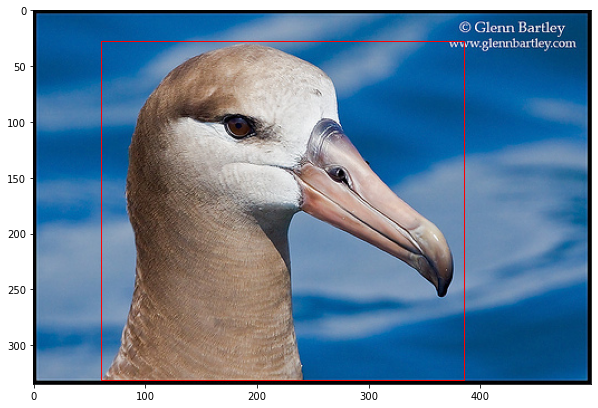

In [9]:
cub_img_base_path = cub_path+"/images/"

idx = 0

img = Image.open(cub_img_base_path+cub_bounding_boxes_df.loc[idx, "path"])
img = np.asarray(img)
x = int(cub_bounding_boxes_df.loc[idx, "x"])
y = int(cub_bounding_boxes_df.loc[idx, "y"])
width = int(cub_bounding_boxes_df.loc[idx, "width"])
height = int(cub_bounding_boxes_df.loc[idx, "height"])

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)
rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

### load img from CUB

In [10]:
def get_cub_img_and_box_by_idx(idx, cub_img_base_path, cub_img_bounding_boxes_df):
    img_path = cub_img_base_path+cub_img_bounding_boxes_df.loc[idx, "path"]
    img = Image.open(img_path)
    img = np.asarray(img)
    
    x = int(cub_img_bounding_boxes_df.loc[idx, "x"])
    y = int(cub_img_bounding_boxes_df.loc[idx, "y"])
    width = int(cub_img_bounding_boxes_df.loc[idx, "width"])
    height = int(cub_img_bounding_boxes_df.loc[idx, "height"])
    
    return img, {"x":x, "y":y, "width":width, "height":height}, img_path

In [11]:
# set the id of the img to load
idx = 1

In [12]:
im_resize = (224,224)
img, box, img_path = get_cub_img_and_box_by_idx(idx, cub_img_base_path, cub_bounding_boxes_df)
preprocessed_img_tensor, resized_img = preprocess_image(img, im_resize)

def get_resize_box(box, org_img_shape, new_img_shape):
    new_x = int(box["x"] * new_img_shape[1] / org_img_shape[1])
    new_y = int(box["y"] * new_img_shape[0] / org_img_shape[0])
    new_width = int(box["width"] * new_img_shape[1] / org_img_shape[1])
    new_height = int(box["height"] * new_img_shape[0] / org_img_shape[0])
    
    return {"x":new_x, "y":new_y, "width":new_width, "height":new_height}

new_box = get_resize_box(box, img.shape, im_resize)

def get_mask_of_box(box,img_shape):
    mask_of_box = np.zeros(img_shape)
    mask_of_box[box["y"]:box["y"]+box["height"]+1,box["x"]:box["x"]+box["width"]+1] = 1
    return mask_of_box
mask_of_box = get_mask_of_box(new_box, im_resize)
#box {"x":x, "y":y, "width":width, "height":height}

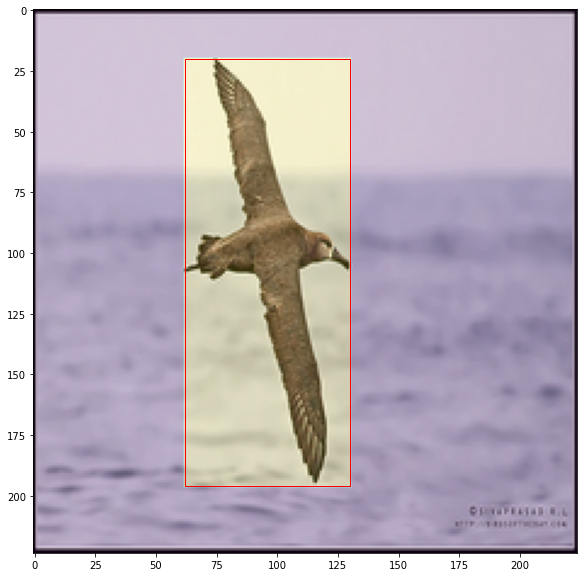

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(resized_img)
rect = patches.Rectangle((new_box["x"], new_box["y"]), new_box["width"], new_box["height"], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.imshow(mask_of_box, alpha=0.2)

### load concept classifier (VGG19)

In [14]:
clf_dict = load_obj("output/concept_clf/concept_clf_bird_vgg19")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'bird classifier', 'model': 'vgg19', 'layer': 'features.30'}


### get feature map and saliency map (VGG19)

In [15]:
model_name = "vgg19"

which_layer_to_hook = ["features.30"]

salient_method = GuidedBackprop

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), st

In [16]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [17]:
chosen_layer = which_layer_to_hook[0]

### localization

In [18]:
pred = prediction(clf, feature_map[chosen_layer])

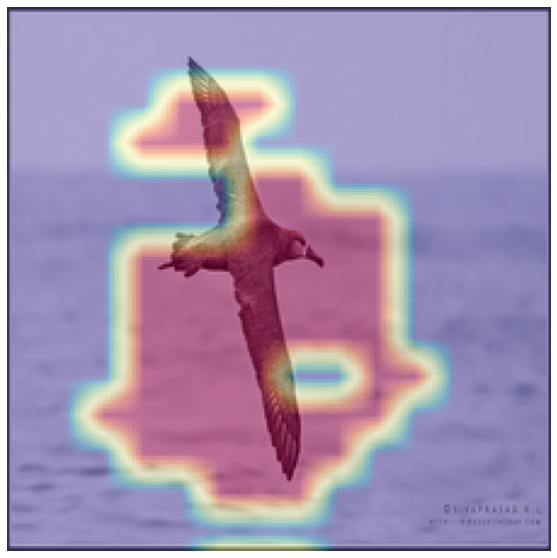

In [19]:
show_concept_region_on_img(resized_img, pred)

### calculate acc

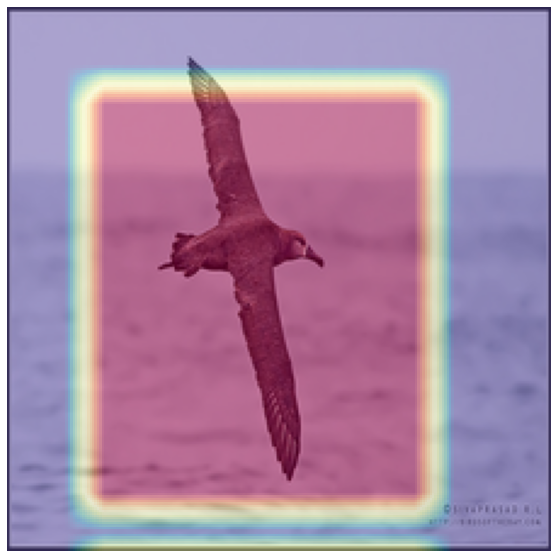

In [20]:
def get_the_box_of_localization(mask):
    locs = np.where(mask>0)
    max_y = np.max(locs[0])
    max_x = np.max(locs[1])
    min_y = np.min(locs[0])
    min_x = np.min(locs[1])
    
    mask_box = np.zeros(mask.shape)
    mask_box[min_y:max_y+1, min_x:max_x+1] = 1
    
    return mask_box

show_concept_region_on_img(resized_img, get_the_box_of_localization(pred))

In [21]:
def get_iou(gt, pred):
    return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))

def cal_iou_of_gt_and_pred_box(gt_box, pred_box):
    resize_pred_box = np.array(resize(np.array(pred_box, dtype=float), (gt_box.shape[0], gt_box.shape[1]))>0, dtype=int)
    return get_iou(gt_box, resize_pred_box)

cal_iou_of_gt_and_pred_box(mask_of_box, get_the_box_of_localization(pred))

/tmp/ipykernel_35857/3858985961.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))


0.3698413681992812

### For ResNet50

load concept clf

In [22]:
clf_dict = load_obj("output/concept_clf/concept_clf_animal_resnet50")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'animal classifier', 'model': 'resnet50', 'layer': 'layer3.5'}


load model

In [23]:
model_name = "resnet50"

which_layer_to_hook = ["layer3.5"]

salient_method = GuidedBackprop

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [24]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [25]:
chosen_layer = which_layer_to_hook[0]

In [26]:
pred = prediction(clf, feature_map[chosen_layer])

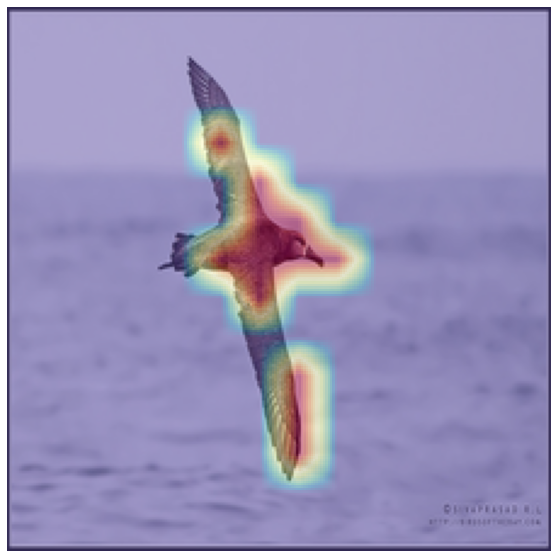

In [27]:
show_concept_region_on_img(resized_img, pred)

In [28]:
cal_iou_of_gt_and_pred_box(mask_of_box, get_the_box_of_localization(pred))

/tmp/ipykernel_35857/3858985961.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))


0.5881269841269842

### For inception_v3

load concept clf

In [29]:
clf_dict = load_obj("output/concept_clf/concept_clf_whole_inception_v3")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'whole classifier', 'model': 'inception_v3', 'layer': 'Mixed_6b'}


load model

In [30]:
model_name = "inception_v3"

which_layer_to_hook = ["Mixed_6b"]

salient_method = SmoothGrad

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_

In [31]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

SmoothGrad
Vanilla Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [32]:
chosen_layer = which_layer_to_hook[0]

In [33]:
pred = prediction(clf, feature_map[chosen_layer])

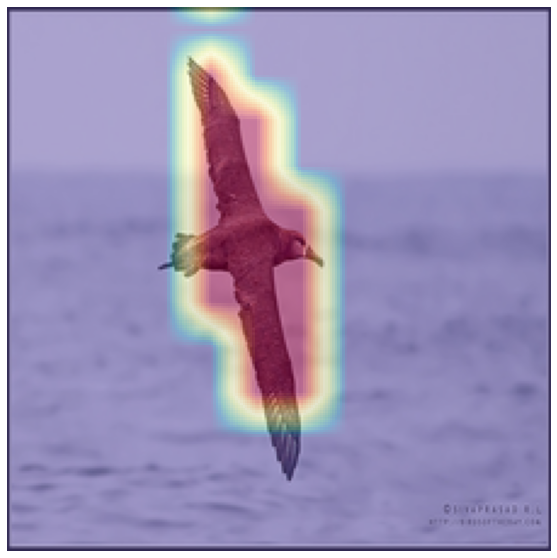

In [34]:
show_concept_region_on_img(resized_img, pred)

In [35]:
cal_iou_of_gt_and_pred_box(mask_of_box, get_the_box_of_localization(pred))

/tmp/ipykernel_35857/3858985961.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))


0.6850456168187228

### For vgg16

load concept clf

In [36]:
clf_dict = load_obj("output/concept_clf/concept_clf_whole_vgg16")
clf = clf_dict["clf"]
print(clf_dict["info"])

{'name': 'whole classifier', 'model': 'vgg16', 'layer': 'features.26'}


load model

In [37]:
model_name = "vgg16"

which_layer_to_hook = ["features.26"]

salient_method = GuidedBackprop

pretrained_model = get_pretrained_model(model_name, True)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("model structure:\n"+str(pretrained_model))

model structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

In [38]:
saliency_map, feature_map, _ = conduct_saliency_map_method(salient_method, preprocessed_img_tensor, None,
                                                           pretrained_model, which_layer_to_hook=which_layer_to_hook,
                                                           device=device)

Guided Backpropagation


/home/v-andongwang/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [39]:
chosen_layer = which_layer_to_hook[0]

In [40]:
pred = prediction(clf, feature_map[chosen_layer])

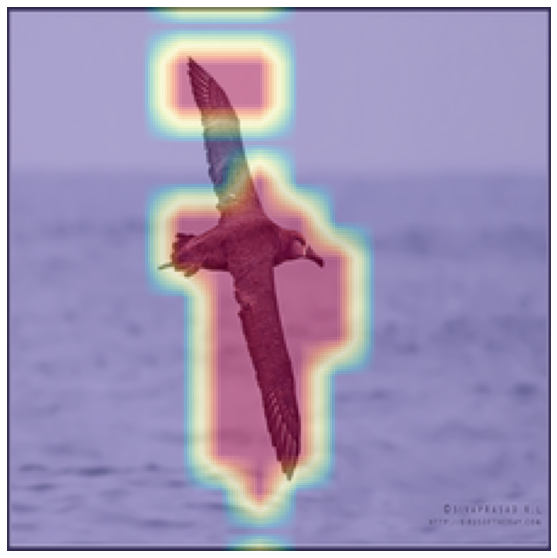

In [41]:
show_concept_region_on_img(resized_img, pred)

In [42]:
cal_iou_of_gt_and_pred_box(mask_of_box, get_the_box_of_localization(pred))

/tmp/ipykernel_35857/3858985961.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(np.multiply(pred, gt)) / np.sum(np.array(gt+pred>0, dtype=np.int))


0.5679408482142857